## 尝试剔除测井曲线的一些异常值


除了使用统计方法（如 3σ 法则、箱线图）识别离群点外，我们还可以根据测井原理和地质知识，预先定义一些不合理的数值范围。

以下是一些可以先验地认为是异常值的建议和理由：

1.  **GR (自然伽马, API)**

    - **异常值:** `< 0`
    - **理由:** GR 测量的是地层的自然放射性强度，其物理意义决定了它不可能是负值。出现负值通常是由于仪器刻度或数据处理过程中的基线漂移导致的错误。

2.  **DEN (或 RHOB, 密度, g/cm³)**

    - **异常值:** `< 1.0`
    - **理由:**
      - 密度值小于 1.0 g/cm³ (水的密度) 是不符合物理规律的，除非在极特殊情况下（如充气井眼）。这通常表示井眼严重扩径（washout），导致密度工具测量到的是密度较低的钻井液而不是地层。

3.  **DT (或 AC, 声波时差, us/ft)**

    - **异常值:** `< 40` 或 `> 200`
    - **理由:**
      - 声波时差反映了声波穿过单位距离地层所需的时间。即使是完全致密、无孔隙的岩石（如石英，时差约 55.5 us/ft；白云石，约 43.5 us/ft），其时差值也很难低于 40 us/ft。低于这个值通常是所谓的“跳周”（cycle skipping）现象，是声波仪器在复杂井眼条件下的一种典型错误。
      - 大于 200 us/ft 的值表示地层非常疏松或声速极慢。虽然钻井液的时差大约在 189 us/ft，井眼垮塌区域可能出现高值，但持续高于 200 us/ft 的数据点很可能是异常的，特别是在非欠压实地层中。

4.  **CAL (井径, in)**

    - **异常值:** 小于钻头尺寸 (e.g., `< 8.5`) 或 远大于钻头尺寸 (e.g., `> 16`)
    - **理由:**
      - 井径曲线反映了井眼的尺寸。它的值理论上不应小于钻井时使用的钻头尺寸（例如，在 8.5 英寸的井眼中，CAL 不应小于 8.5）。小于钻头尺寸的值可能表示仪器问题或井壁上形成了厚厚的泥饼。
      - 远大于钻头尺寸的值表示井眼严重扩径或存在大的溶洞。虽然扩径是正常现象，但一个过大的阈值（如 16 英寸）可以帮助我们识别那些可能对其他测井响应产生严重影响的层段。

5.  **LLD (深侧向电阻率, ohm.m)**
    - **异常值:** `< 0.1` 或 `> 2000`
    - **理由:**
      - 电阻率不应为负值，任何负值都是错误。极低的值（如小于 0.1 ohm.m）虽然在某些高矿化度盐水层中可能出现，但在常规油气藏勘探中非常罕见，通常表示仪器短路或数据错误。
      - 电阻率可以非常高（如在致密碳酸盐岩、煤层、油气层中）。设置一个上限（如 2000 ohm.m）主要是为了处理仪器超出量程或“无穷大”的情况。在对数坐标下，这些极高值会严重影响可视化和统计分析，通常会将它们限制（clip）在一个合理的最高值。


In [9]:
import os
from pathlib import Path
from typing import Dict, Tuple

import lasio
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# 设置中文字体支持
plt.rcParams["font.sans-serif"] = ["SimHei", "DejaVu Sans"]
plt.rcParams["axes.unicode_minus"] = False


In [10]:
# 定义路径
las_folder = "../data/vertical_well_truncated_las"
output_folder = "../data/vertical_well_las_delete_outliers"

# 创建输出文件夹
output_path = Path(output_folder)
output_path.mkdir(parents=True, exist_ok=True)

# 定义异常值规则
ANOMALY_RULES = {
    "GR": {"min": 0, "max": None, "description": "GR不能为负值（物理意义）"},
    "DEN": {"min": 1.0, "max": 3.0, "description": "密度小于1.0表示井眼扩径或钻井液，大于3.0不合理"},
    "RHOB": {"min": 1.0, "max": 3.0, "description": "密度小于1.0表示井眼扩径或钻井液，大于3.0不合理"},
    "DT": {"min": 40, "max": 200, "description": "小于40为跳周现象，大于200表示极疏松地层或异常"},
    "AC": {"min": 40, "max": 200, "description": "小于40为跳周现象,大于200表示极疏松地层或异常"},
    "CAL": {"min": 8.5, "max": 16.0, "description": "井径不应小于钻头尺寸，远大于钻头尺寸表示严重扩径"},
    "CALI": {"min": 8.5, "max": 16.0, "description": "井径不应小于钻头尺寸，远大于钻头尺寸表示严重扩径"},
    "LLD": {"min": 0.1, "max": 2000, "description": "极低值表示仪器短路，极高值需要截断"},
    "LLD1": {"min": 0.1, "max": 2000, "description": "极低值表示仪器短路，极高值需要截断"},
}


def detect_anomalies(data: np.ndarray, min_val: float = None, max_val: float = None) -> np.ndarray:  # type: ignore
    """
    检测异常值

    Parameters:
    -----------
    data : np.ndarray
        测井数据
    min_val : float
        最小合理值
    max_val : float
        最大合理值

    Returns:
    --------
    mask : np.ndarray
        异常值掩码（True表示异常）
    """
    mask = np.zeros(len(data), dtype=bool)

    # 检测NaN
    mask |= np.isnan(data)

    # 检测无穷大
    mask |= np.isinf(data)

    # 检测超出范围的值
    if min_val is not None:
        mask |= data < min_val

    if max_val is not None:
        mask |= data > max_val

    return mask


def apply_statistical_filter(data: np.ndarray, sigma: float = 3.0) -> np.ndarray:
    """
    应用3σ法则检测离群点

    Parameters:
    -----------
    data : np.ndarray
        测井数据
    sigma : float
        标准差倍数，默认3

    Returns:
    --------
    mask : np.ndarray
        离群点掩码（True表示离群）
    """
    # 排除NaN和Inf
    valid_data = data[~np.isnan(data) & ~np.isinf(data)]

    if len(valid_data) == 0:
        return np.zeros(len(data), dtype=bool)

    mean = np.mean(valid_data)
    std = np.std(valid_data)

    mask = np.abs(data - mean) > (sigma * std)

    return mask


def get_curve_mnemonic(las: lasio.LASFile, possible_names: list) -> str:
    """
    根据可能的名称列表查找曲线

    Parameters:
    -----------
    las : lasio.LASFile
        LAS文件对象
    possible_names : list
        可能的曲线名称列表

    Returns:
    --------
    mnemonic : str or None
        找到的曲线名称
    """
    curve_mnemonics = [c.mnemonic for c in las.curves]

    for name in possible_names:
        if name in curve_mnemonics:
            return name

    return None  # type: ignore


print("=" * 80)
print("测井曲线异常值处理")
print("=" * 80)
print("\n异常值规则:")
for curve, rule in ANOMALY_RULES.items():
    min_str = f"{rule['min']}" if rule["min"] is not None else "无限制"
    max_str = f"{rule['max']}" if rule["max"] is not None else "无限制"
    print(f"  {curve:8s}: [{min_str:8s}, {max_str:8s}] - {rule['description']}")


测井曲线异常值处理

异常值规则:
  GR      : [0       , 无限制     ] - GR不能为负值（物理意义）
  DEN     : [1.0     , 3.0     ] - 密度小于1.0表示井眼扩径或钻井液，大于3.0不合理
  RHOB    : [1.0     , 3.0     ] - 密度小于1.0表示井眼扩径或钻井液，大于3.0不合理
  DT      : [40      , 200     ] - 小于40为跳周现象，大于200表示极疏松地层或异常
  AC      : [40      , 200     ] - 小于40为跳周现象,大于200表示极疏松地层或异常
  CAL     : [8.5     , 16.0    ] - 井径不应小于钻头尺寸，远大于钻头尺寸表示严重扩径
  CALI    : [8.5     , 16.0    ] - 井径不应小于钻头尺寸，远大于钻头尺寸表示严重扩径
  LLD     : [0.1     , 2000    ] - 极低值表示仪器短路，极高值需要截断
  LLD1    : [0.1     , 2000    ] - 极低值表示仪器短路，极高值需要截断


In [11]:
# 获取所有LAS文件
input_path = Path(las_folder)
las_files = list(input_path.glob("*.las"))
las_files = list(set(las_files))
las_files.sort()

if not las_files:
    print(f"\n在 {las_folder} 中未找到LAS文件")
else:
    print(f"\n找到 {len(las_files)} 个LAS文件")
    print("=" * 80)

    # 统计信息
    processing_stats = []
    success_count = 0
    failed_files = []

    for las_file in las_files:
        well_name = las_file.stem
        print(f"\n{'=' * 80}")
        print(f"处理井: {well_name}")
        print(f"{'=' * 80}")

        try:
            # 读取LAS文件
            las = lasio.read(las_file, mnemonic_case="upper")

            # 统计该井的异常值信息
            well_stats = {"Well": well_name}

            # 创建新的LAS对象
            new_las = lasio.LASFile()
            new_las.version = las.version
            new_las.well = las.well
            new_las.params = las.params
            new_las.other = las.other

            # 处理每条曲线
            for curve in las.curves:
                mnemonic = curve.mnemonic
                data = curve.data.copy()
                original_count = len(data)

                # 检查是否有对应的异常值规则
                rule = ANOMALY_RULES.get(mnemonic)

                if rule is not None:
                    print(f"\n曲线: {mnemonic}")
                    print(f"  原始数据点数: {original_count}")

                    # 先验异常值检测
                    prior_mask = detect_anomalies(data, min_val=rule["min"], max_val=rule["max"])
                    prior_anomaly_count = np.sum(prior_mask)
                    prior_anomaly_pct = (prior_anomaly_count / original_count) * 100

                    print(f"  先验异常值: {prior_anomaly_count} ({prior_anomaly_pct:.2f}%)")

                    # 3σ统计异常值检测（仅对非先验异常值应用）
                    valid_data = data[~prior_mask]
                    if len(valid_data) > 0:
                        # 对整个数据应用3σ检测
                        statistical_mask = apply_statistical_filter(data, sigma=3.0)
                        # 但只统计非先验异常的部分
                        statistical_only_mask = statistical_mask & ~prior_mask
                        statistical_anomaly_count = np.sum(statistical_only_mask)
                        statistical_anomaly_pct = (statistical_anomaly_count / original_count) * 100

                        print(f"  统计离群值(3σ): {statistical_anomaly_count} ({statistical_anomaly_pct:.2f}%)")

                        # 合并所有异常值
                        total_mask = prior_mask | statistical_mask
                    else:
                        total_mask = prior_mask
                        statistical_anomaly_count = 0
                        statistical_anomaly_pct = 0.0

                    total_anomaly_count = np.sum(total_mask)
                    total_anomaly_pct = (total_anomaly_count / original_count) * 100

                    print(f"  总异常值: {total_anomaly_count} ({total_anomaly_pct:.2f}%)")

                    # 将异常值设为NaN
                    data[total_mask] = np.nan

                    valid_count = np.sum(~np.isnan(data))
                    print(f"  有效数据点数: {valid_count}")

                    # 记录统计信息（数量和百分比）
                    well_stats[f"{mnemonic}_Points"] = original_count  # type: ignore
                    well_stats[f"{mnemonic}_Prior_Count"] = prior_anomaly_count
                    well_stats[f"{mnemonic}_Prior_Pct"] = prior_anomaly_pct
                    well_stats[f"{mnemonic}_Statistical_Count"] = statistical_anomaly_count  # type: ignore
                    well_stats[f"{mnemonic}_Statistical_Pct"] = statistical_anomaly_pct  # type: ignore
                    well_stats[f"{mnemonic}_Total_Count"] = total_anomaly_count  # type: ignore
                    well_stats[f"{mnemonic}_Total_Pct"] = total_anomaly_pct  # type: ignore
                    well_stats[f"{mnemonic}_Valid_Count"] = valid_count

                else:
                    # 对于没有先验规则的曲线，只进行基本的NaN和Inf检测
                    basic_mask = np.isnan(data) | np.isinf(data)
                    basic_anomaly_count = np.sum(basic_mask)

                    if basic_anomaly_count > 0:
                        print(f"\n曲线: {mnemonic}")
                        print(f"  原始数据点数: {original_count}")
                        print(f"  NaN/Inf异常: {basic_anomaly_count}")
                        data[basic_mask] = np.nan

                # 添加处理后的曲线
                new_las.append_curve(
                    mnemonic=curve.mnemonic, data=data, unit=curve.unit, descr=curve.descr, value=curve.value
                )

            # 保存处理后的文件
            output_file = output_path / las_file.name
            new_las.write(str(output_file), version=2.0)

            print(f"\n✓ 成功处理并保存到 {output_file.name}")
            success_count += 1

            # 保存统计信息
            processing_stats.append(well_stats)

        except Exception as e:
            print(f"\n✗ 处理失败: {e}")
            import traceback

            traceback.print_exc()
            failed_files.append((well_name, str(e)))

    # 保存处理统计信息
    if processing_stats:
        stats_df = pd.DataFrame(processing_stats)
        stats_file = "output/processing_statistics.xlsx"
        stats_df.to_excel(stats_file, index=False)
        print(f"\n统计信息已保存到: {stats_file}")

    # 输出总体统计
    print("\n" + "=" * 80)
    print("处理完成！")
    print("=" * 80)
    print(f"成功: {success_count}/{len(las_files)}")

    if failed_files:
        print(f"\n失败的文件:")
        for filename, error in failed_files:
            print(f"  - {filename}: {error}")



找到 5 个LAS文件

处理井: PH1

曲线: CAL
  原始数据点数: 9353
  先验异常值: 0 (0.00%)
  统计离群值(3σ): 0 (0.00%)
  总异常值: 0 (0.00%)
  有效数据点数: 9353

曲线: DEN
  原始数据点数: 9353
  先验异常值: 0 (0.00%)
  统计离群值(3σ): 0 (0.00%)
  总异常值: 0 (0.00%)
  有效数据点数: 9353

曲线: DT
  原始数据点数: 9353
  先验异常值: 0 (0.00%)
  统计离群值(3σ): 283 (3.03%)
  总异常值: 283 (3.03%)
  有效数据点数: 9070

曲线: FACIES
  原始数据点数: 9353
  NaN/Inf异常: 1441

曲线: FLUIDS
  原始数据点数: 9353
  NaN/Inf异常: 5723

曲线: GR
  原始数据点数: 9353
  先验异常值: 0 (0.00%)
  统计离群值(3σ): 0 (0.00%)
  总异常值: 0 (0.00%)
  有效数据点数: 9353

曲线: GR-NORM
  原始数据点数: 9353
  NaN/Inf异常: 56

曲线: INPEFA
  原始数据点数: 9353
  NaN/Inf异常: 1352

曲线: LLD1
  原始数据点数: 9353
  先验异常值: 0 (0.00%)
  统计离群值(3σ): 164 (1.75%)
  总异常值: 164 (1.75%)
  有效数据点数: 9189

曲线: MLP-YC
  原始数据点数: 9353
  NaN/Inf异常: 1523

曲线: PEFA
  原始数据点数: 9353
  NaN/Inf异常: 1352

曲线: PERM
  原始数据点数: 9353
  NaN/Inf异常: 1712

曲线: POR
  原始数据点数: 9353
  NaN/Inf异常: 1577

曲线: SAND??SHADIBI
  原始数据点数: 9353
  NaN/Inf异常: 1441

曲线: SVM-YC
  原始数据点数: 9353
  NaN/Inf异常: 1523

曲线: SW
  原始数据点数: 9353
  N

C:\Users\WangQinZhuo\AppData\Local\Temp\ipykernel_22200\387287124.py:79: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()



统计图表已保存到: output/anomaly_statistics.png

异常值统计摘要

各曲线平均异常值占比:
  GR      : 平均  0.14%  最大  0.66% (PH5)
  DEN     : 平均  0.66%  最大  2.35% (PH5)
  DT      : 平均  3.02%  最大  3.54% (PH5)
  CAL     : 平均  1.98%  最大  4.53% (PH5)
  LLD1    : 平均  2.15%  最大  3.45% (PH5)

异常值占比最高的5口井:
  PH5                 :  2.91%
  PH4                 :  1.75%
  PH2                 :  1.39%
  PH1                 :  0.96%
  PH3                 :  0.95%

各曲线总异常值数量:
  GR      : 总计     58  最大     56 (PH5)
  DEN     : 总计    266  最大    199 (PH5)
  DT      : 总计   1226  最大    300 (PH5)
  CAL     : 总计    817  最大    384 (PH5)
  LLD1    : 总计    874  最大    292 (PH5)


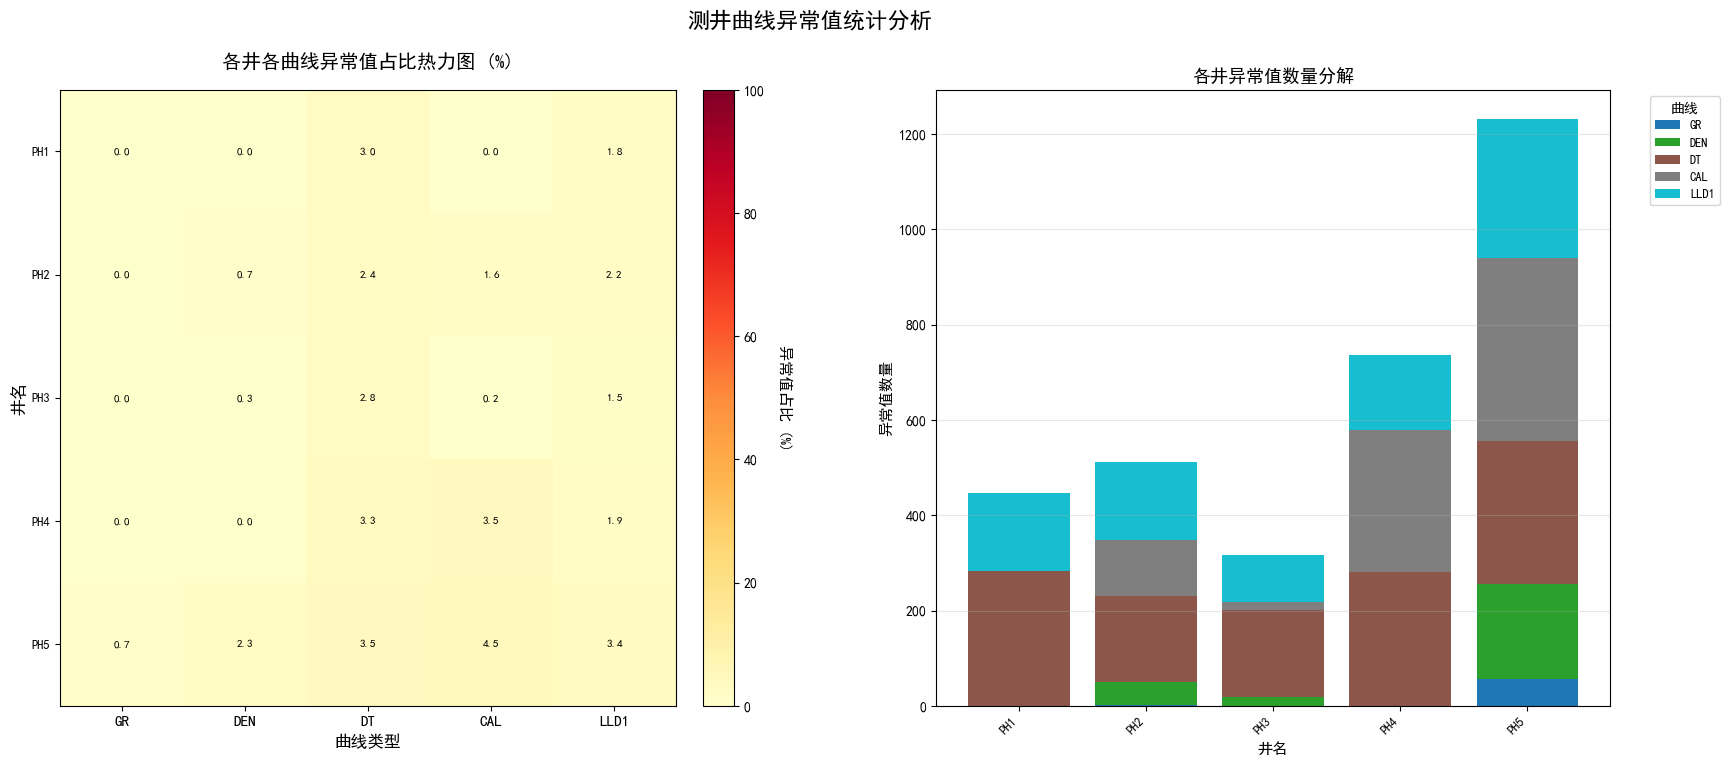

In [12]:
# 可视化统计结果
if processing_stats:
    stats_df = pd.DataFrame(processing_stats)

    # 统计各曲线的异常值情况
    curves_to_analyze = ["GR", "DEN", "RHOB", "DT", "AC", "CAL", "CALI", "LLD", "LLD1"]

    # 提取异常值百分比数据用于热力图
    anomaly_pct_data = {}
    for curve in curves_to_analyze:
        pct_col = f"{curve}_Total_Pct"
        if pct_col in stats_df.columns:
            anomaly_pct_data[curve] = stats_df[pct_col].fillna(0).values

    # 提取异常值数量数据用于柱状图
    anomaly_counts = {}
    for curve in curves_to_analyze:
        count_col = f"{curve}_Total_Count"
        if count_col in stats_df.columns:
            anomaly_counts[curve] = stats_df[count_col].fillna(0).values

    # 创建图表 (1行2列布局)
    fig = plt.figure(figsize=(20, 8))
    gs = fig.add_gridspec(1, 2, hspace=0.3, wspace=0.3)

    # 1. 热力图：各井各曲线异常值占比
    if anomaly_pct_data:
        ax1 = fig.add_subplot(gs[0, 0])
        pct_df = pd.DataFrame(anomaly_pct_data, index=stats_df["Well"])
        pct_df_filtered = pct_df.loc[:, (pct_df > 0).any()]

        if len(pct_df_filtered.columns) > 0:
            im = ax1.imshow(pct_df_filtered.values, cmap="YlOrRd", aspect="auto", vmin=0, vmax=100)
            ax1.set_xticks(range(len(pct_df_filtered.columns)))
            ax1.set_xticklabels(pct_df_filtered.columns, fontsize=11, fontweight="bold")
            ax1.set_yticks(range(len(pct_df_filtered.index)))
            ax1.set_yticklabels([name[:15] for name in pct_df_filtered.index], fontsize=9)
            ax1.set_title("各井各曲线异常值占比热力图 (%)", fontweight="bold", fontsize=14, pad=15)
            ax1.set_xlabel("曲线类型", fontsize=12, fontweight="bold")
            ax1.set_ylabel("井名", fontsize=12, fontweight="bold")

            # 添加颜色条
            cbar = plt.colorbar(im, ax=ax1, fraction=0.046, pad=0.04)
            cbar.set_label("异常值占比 (%)", rotation=270, labelpad=20, fontsize=11)

            # 在热力图上标注数值
            for i in range(len(pct_df_filtered.index)):
                for j in range(len(pct_df_filtered.columns)):
                    value = pct_df_filtered.values[i, j]
                    # if value > 0:
                    text_color = "white" if value > 50 else "black"
                    ax1.text(
                        j,
                        i,
                        f"{value:.1f}",
                        ha="center",
                        va="center",
                        color=text_color,
                        fontsize=8,
                        fontweight="bold",
                    )

    # 2. 堆叠柱状图：各井异常值数量分解
    if anomaly_counts:
        ax2 = fig.add_subplot(gs[0, 1])
        counts_df = pd.DataFrame(anomaly_counts, index=stats_df["Well"])
        counts_df_filtered = counts_df.loc[:, (counts_df > 0).any()]

        if len(counts_df_filtered.columns) > 0:
            counts_df_filtered.plot(kind="bar", stacked=True, ax=ax2, colormap="tab10", width=0.8)
            ax2.set_title("各井异常值数量分解", fontweight="bold", fontsize=13)
            ax2.set_xlabel("井名", fontsize=11)
            ax2.set_ylabel("异常值数量", fontsize=11)
            ax2.legend(title="曲线", bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=9)
            ax2.set_xticklabels([name[:12] for name in counts_df_filtered.index], rotation=45, ha="right", fontsize=9)
            ax2.grid(axis="y", alpha=0.3)

    fig.suptitle("测井曲线异常值统计分析", fontsize=16, fontweight="bold", y=0.98)
    plt.tight_layout()

    # 保存图表
    fig_file = "output/anomaly_statistics.png"
    plt.savefig(fig_file, dpi=300, bbox_inches="tight")
    print(f"\n统计图表已保存到: {fig_file}")

    # 输出统计摘要
    print("\n" + "=" * 80)
    print("异常值统计摘要")
    print("=" * 80)

    if anomaly_pct_data:
        pct_df = pd.DataFrame(anomaly_pct_data, index=stats_df["Well"])
        print("\n各曲线平均异常值占比:")
        for col in pct_df.columns:
            if pct_df[col].sum() > 0:
                avg_pct = pct_df[col].mean()
                max_pct = pct_df[col].max()
                max_well = pct_df[col].idxmax()
                print(f"  {col:8s}: 平均 {avg_pct:5.2f}%  最大 {max_pct:5.2f}% ({max_well})")

        print("\n异常值占比最高的5口井:")
        well_avg = pct_df.mean(axis=1).sort_values(ascending=False).head(5)
        for well, avg in well_avg.items():
            print(f"  {well:20s}: {avg:5.2f}%")

    if anomaly_counts:
        counts_df = pd.DataFrame(anomaly_counts, index=stats_df["Well"])
        counts_df_filtered = counts_df.loc[:, (counts_df > 0).any()]
        if len(counts_df_filtered.columns) > 0:
            print("\n各曲线总异常值数量:")
            for col in counts_df_filtered.columns:
                total_count = counts_df_filtered[col].sum()
                max_count = counts_df_filtered[col].max()
                max_well = counts_df_filtered[col].idxmax()
                print(f"  {col:8s}: 总计 {total_count:6.0f}  最大 {max_count:6.0f} ({max_well})")

    plt.show()